In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from vplot import colors
import astropy.units as u
import rebound

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Eccentricity space

The following creates Fig. 1.

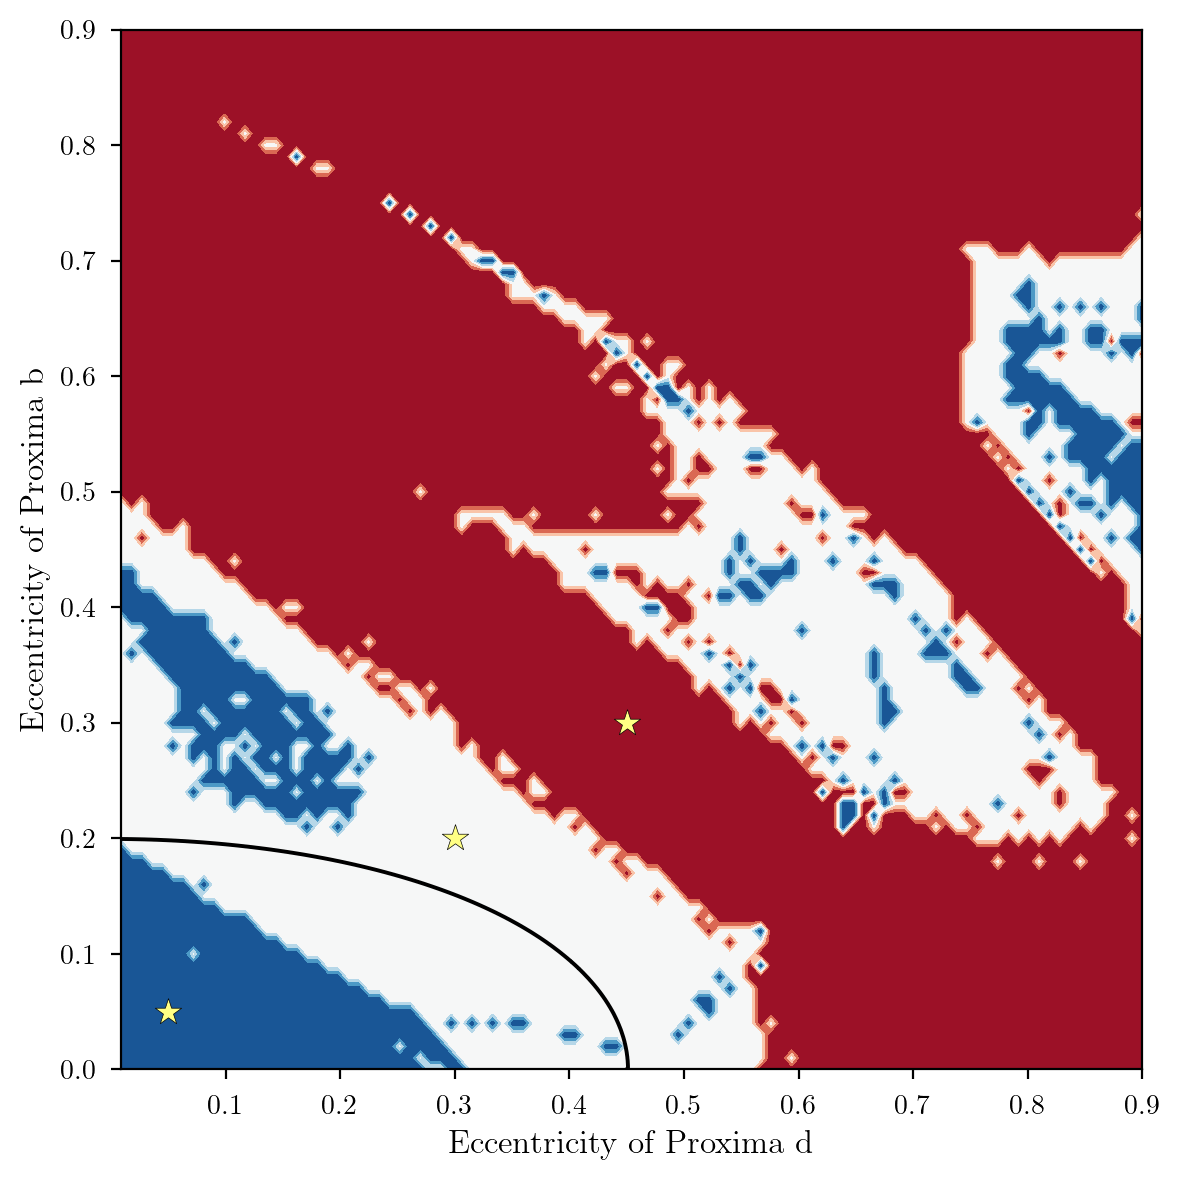

In [2]:
# megno_map_file = '~/Documents/GitHub/ProximaEvolution/hill-stability/ecc-megno-2.txt'
# megno_map_supp = '~/Documents/GitHub/ProximaEvolution/hill-stability/ecc-megno-supp.txt'
# hill_stab_file = '~/Documents/GitHub/ProximaEvolution/hill-stability/proxhillstabecc.txt'

megno_map_file = 'ecc-megno.txt'
megno_supp_file = None
hill_stab_file = 'proxhillstab.txt'

column_names = ['d_mass', 'b_mass', 'd_semi', 'b_semi', 'd_ecc', 'b_ecc', 'd_inc', 'b_inc', 'd_Omega', 'b_Omega', 'd_pomega', 'b_pomega', 'megno']
df = pd.read_csv(megno_map_file, sep=' ', names=column_names, index_col=False)

# Apply masks
stable_df = df.mask(np.fabs(df['megno'] - 2.) > 1.0e-2).mask(df['megno'] == 10.).dropna()
unstable_df = df.mask(np.fabs(df['megno'] - 2.) < 1.0e-2).mask(df['megno'] == 10.).dropna()
escape_df = df.mask(df['megno'] != 10.).dropna() # we arbitrarily set MEGNO to 10.0 where escape occurs

# Hill stability data (calculated with prox_hill_stab.c)
hill_stab_cols = ['exact', 'approx', 'd_mass', 'b_mass', 'd_semi', 'b_semi',
                'd_ecc', 'b_ecc', 'd_aper', 'b_aper', 'd_inc', 'b_inc',
                'd_lasc', 'b_lasc', 'd_mean_an', 'b_mean_an']
hillstab = pd.read_csv(hill_stab_file, sep=' ', names=hill_stab_cols, index_col=False)

# Cleaning up the data
df = df.drop_duplicates(subset=['d_ecc', 'b_ecc'])
if megno_map_supp != None:
    df_supp = pd.read_csv(megno_map_supp, sep=' ', names=column_names, index_col=False)
    df_supp = df_supp.drop_duplicates(subset=['d_ecc', 'b_ecc'])
    df = pd.concat([df, df_supp]).drop_duplicates(subset=['d_ecc', 'b_ecc'])

d_ecc_list = list(df['d_ecc'])
b_ecc_list = list(df['b_ecc'])
d_ecc = []
b_ecc = []
for de in d_ecc_list:
    if de not in d_ecc:
        d_ecc.append(de)
for be in b_ecc_list:
    if be not in b_ecc:
        b_ecc.append(be)
for de in d_ecc:
    for be in b_ecc:
        if df[(np.abs(df['d_ecc'] - de) <= 0.005) & (np.abs(df['b_ecc'] - be) <= 0.005)].index.tolist() == []:
            new_row = {'d_ecc': de, 'b_ecc': be, 'megno': 0.}
            df = df.append(new_row, ignore_index=True)
df = df.drop_duplicates(subset=['d_ecc', 'b_ecc'])
df = df.sort_values(by=['b_ecc', 'd_ecc'])

# Assign quasi-periodic/chaotic/unstable designation
orbit_type = np.zeros((100, 91))
for k in range(len(df['megno'])):
    i = k % 100
    j = int(np.floor(k/100))
    if np.fabs(df['megno'].iloc[k] - 2.) <= 1e-2: # Criterion of Hinse et al. (2010)
        orbit_type[i][j] = 1. # quasi-periodic
    elif (df['megno'].iloc[k] == 10.) or (np.isnan(df['megno'].iloc[k])):
        orbit_type[i][j] = 0. # unstable -- ejection occurs
    elif df['megno'].iloc[k] == 0.:
        orbit_type[i][j] = 0.5 # no data -- for some reason, the simulation didn't finish
    else:
        orbit_type[i][j] = 0.5 # chaotic, but not necessarily unstable

# Make tick labels
d_tick_labels = np.round_(np.linspace(0., 0.9, 100), decimals=2)
b_tick_labels = np.round_(np.linspace(0., 0.9, 91), decimals=2)
d_tick_labels = [str(e) for e in d_tick_labels]
b_tick_labels = [str(e) for e in b_tick_labels]
for i, e in enumerate(d_tick_labels):
    if e not in str(np.linspace(0., 0.9, 10)):
        d_tick_labels[i] = ''
    else:
        d_tick_labels[i] = str(d_tick_labels[i])
for i, e in enumerate(b_tick_labels):
    if e not in str(np.linspace(0., 0.9, 10)):
        b_tick_labels[i] = ''
    else:
        b_tick_labels[i] = str(b_tick_labels[i])

X, Y = np.meshgrid(np.linspace(0.009, 0.9, 100), np.linspace(0., 0.9, 91))

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=200)
# with sns.axes_style('ticks'):
#     hm = sns.heatmap(orbit_type.T,
#                      vmin=0.,
#                      vmax=1.,
#                      cmap='RdBu',
#                      xticklabels=d_tick_labels,
#                      yticklabels=b_tick_labels,
#                      square=True,
#                      cbar=False,
#                      ax=ax
#                     )
ax.contourf(X, Y, orbit_type.T, cmap='RdBu')
ax.tricontour(hillstab['d_ecc'],
              hillstab['b_ecc'],
              hillstab['exact'],
              levels=[1.],
              colors='k'
#               colors=colors.pale_blue
             )

# Limit of crossing orbits
# ax.plot(d_ecc, b_ecc_at_crossing, c='lime', ls='--')

# Locations of simulations in Fig. 2
ax.scatter([0.05, 0.3, 0.45], [0.05, 0.2, 0.3], marker='*', s=100, c='xkcd:pale yellow', edgecolor='k')

# Location of VPLanet simulation in AAS 241 presentation
# ax.scatter(0.0907129347973946, 0.09250015269796305, marker='*', s=200, c='xkcd:pale yellow', edgecolor='k')

# ax.invert_yaxis()
ax.tick_params(which='minor', bottom=False, left=False)
ax.set_xlim(left=0.009)
ax.set_xlabel('Eccentricity of Proxima d')
ax.set_ylabel('Eccentricity of Proxima b');
# fig.savefig('varying-ecc.pdf', dpi=400, bbox_inches='tight')

## Sample simulations with output

The following creates Fig. 2. Note that the second cell below will run three REBOUND simulations that will last for several minutes each.

In [2]:
def phase_delta(d, b):
    """
    Calculate the separation in phase space between the two planets. This verifies the exponential
    increase in the separation for chaotic (MEGNO != 2) evolution.
    """
    xdiff = b.x - d.x
    ydiff = b.y - d.y
    zdiff = b.z - d.z
    vxdiff = b.vx - d.vx
    vydiff = b.vy - d.vy
    vzdiff = b.vz - d.vz
    phase_delta_vec = np.array([xdiff, ydiff, zdiff, vxdiff, vydiff, vzdiff])
    return np.linalg.norm(phase_delta_vec)

def conjunction_longitude(d, b):
    return (2.*b.l - d.l) % (2.*np.pi)

def resonant_argument_1(d, b):
    return (2.*b.l - d.l - d.pomega) % (2.*np.pi)

def resonant_argument_2(d, b):
    return (2.*b.l - d.l - b.pomega) % (2.*np.pi)

def resonant_argument_3(d, b):
    return (3.*b.l - d.l - 2.*d.pomega) % (2.*np.pi)

def resonant_argument_32(d, b):
    return (3.*b.l - 2.*d.l - d.pomega) % (2.*np.pi)

def simulation_with_output(par, integrator='ias15', num_orbit=1.0e6, step_size=100, primary_mass=0.12, M=None):
    """
    Runs a REBOUND simulation with the specified orbital elements for Proxima d & b. Returns DataFrame with
    snapshots of the orbital elements taken every 100 timesteps.
    """
    m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2 = par # unpack parameters
    sim = None
    sim = rebound.Simulation()
    sim.integrator = integrator
    if integrator == 'whfast':
        sim.ri_whfast.safe_mode = False
        sim.ri_whfast.corrector = 11
    sim.add(m=primary_mass)                      # Proxima Centauri
    if M == None:
        sim.add(m=m1, a=a1, e=e1, inc=i1, Omega=Omega1, pomega=pomega1)  # Proxima d
        sim.add(m=m2, a=a2, e=e2, inc=i2, Omega=Omega2, pomega=pomega2)  # Proxima b
    else:
        M1, M2 = M
        sim.add(m=m1, a=a1, e=e1, inc=i1, Omega=Omega1, pomega=pomega1, M=M1)  # Proxima d
        sim.add(m=m2, a=a2, e=e2, inc=i2, Omega=Omega2, pomega=pomega2, M=M2)  # Proxima b
    star = sim.particles[0]
    d = sim.particles[1]
    b = sim.particles[2]
#     sim.dt = 0.05 * d.P # timestep is 5% of Proxima d's orbital period
    sim.dt = 0.01 * d.P # For System A from Barnes et al. (2015)
    sim.move_to_com()
    if integrator == 'ias15':
        sim.ri_ias15.min_dt = 1e-4 * sim.dt
    sim.init_megno()
    sim.exit_max_distance = 20.
    
    energy = sim.calculate_energy()
    delta = phase_delta(d, b)
    conj = conjunction_longitude(d, b)
    phi1 = resonant_argument_1(d, b)
    phi2 = resonant_argument_2(d, b)
    phi3 = resonant_argument_3(d, b)
    phi32 = resonant_argument_32(d, b)
    output = [[0., a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1,
               pomega2, d.l, b.l, 0., 0., 0., 0., energy, 0.,
               delta, conj, phi1, phi2, phi3, phi32]]
    
#     sim.integrate(num_orbit*b.P, exact_finish_time=False)
#     final_energy = sim.calculate_energy()
#     return energy, final_energy
    
    try:
        while sim.t <= num_orbit * b.P: # Integrate num_orbit orbits of Proxima b
            sim.steps(step_size)
            do = d.calculate_orbit(primary=star)
            bo = b.calculate_orbit(primary=star)
            megno = sim.calculate_megno()
            energy = sim.calculate_energy()
            delta = phase_delta(d, b)
            conj = conjunction_longitude(do, bo)
            phi1 = resonant_argument_1(do, bo)
            phi2 = resonant_argument_2(do, bo)
            phi3 = resonant_argument_3(do, bo)
            phi32 = resonant_argument_32(do, bo)
            output.append([sim.t, do.a, bo.a, do.e, bo.e, do.inc, bo.inc, do.Omega, bo.Omega,
                           do.pomega, bo.pomega, do.l, bo.l, do.n, bo.n, do.d, bo.d, energy,
                           megno, delta, conj, phi1, phi2, phi3, phi32])
    except rebound.Escape as ex:
        print(ex)
    megno = sim.calculate_megno()
    column_names = ['time', 'd_semi', 'b_semi', 'd_ecc', 'b_ecc', 'd_inc', 'b_inc', 'd_Omega', 'b_Omega',
                    'd_pomega', 'b_pomega', 'd_lambda', 'b_lambda', 'd_mm', 'b_mm', 'd_dist', 'b_dist',
                    'energy', 'megno', 'delta', 'conj', 'phi1', 'phi2', 'phi3', 'phi32']
    return pd.DataFrame(data=output, columns=column_names)

In [3]:
# Example case with quasi-periodic motion
e1 = 0.05
e2 = 0.05
min_mass1 = float(0.26 * u.earthMass/u.solMass)
min_mass2 = float(1.07 * u.earthMass/u.solMass)
obs_inc1 = 133.
obs_inc2 = 133.
m1 = min_mass1 / np.sin(obs_inc1)
m2 = min_mass2 / np.sin(obs_inc2)
a1 = 0.029
a2 = 0.049
i1 = 0.
i2 = 0.
Omega1 = 0.
Omega2 = np.pi
pomega1 = 0.
pomega2 = np.pi
par = (m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2)
stable_sim = simulation_with_output(par, integrator='whfast')

# Example case with chaotic motion 
e1 = 0.3
e2 = 0.2
par = (m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2)
chaotic_sim = simulation_with_output(par, integrator='whfast')

# Example case with ejection
e1 = 0.45
e2 = 0.3
par = (m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2)
unstable_sim = simulation_with_output(par)

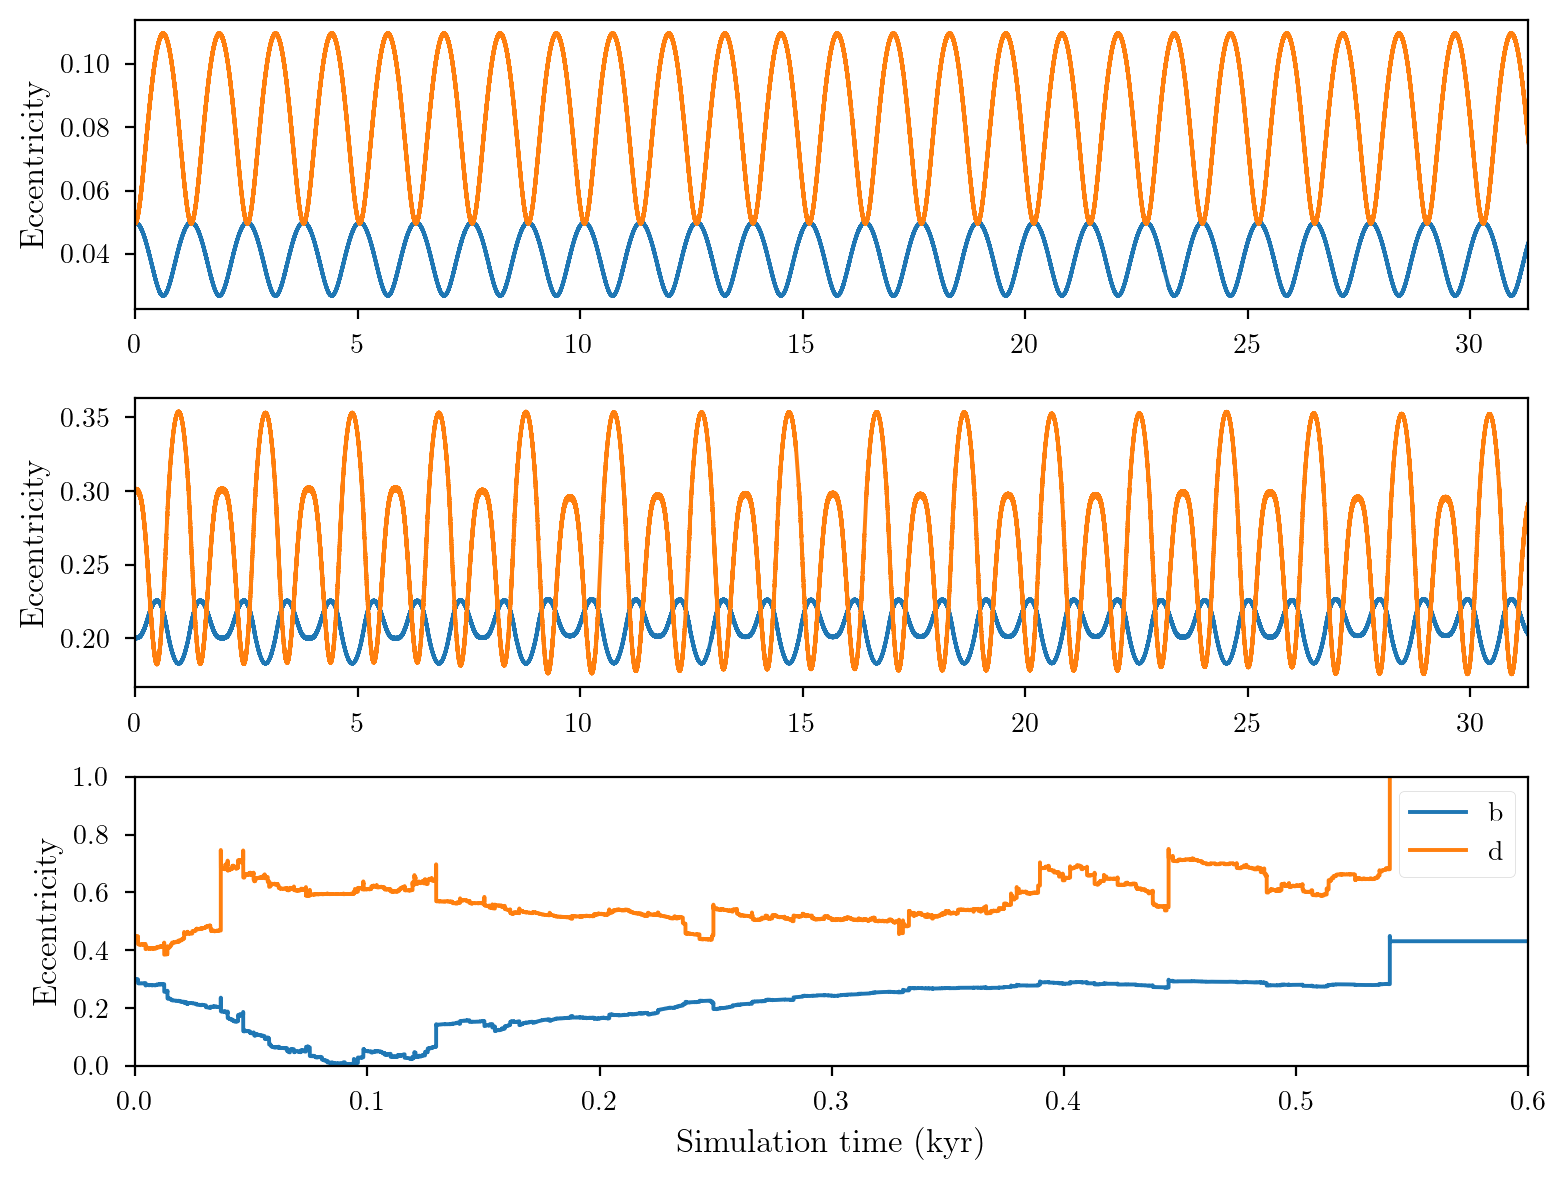

In [9]:
norm = 2. * np.pi * 1000. # conversion from REBOUND time units into kyr

fig, ax = plt.subplots(3, 1, figsize=(8, 6), dpi=200)
ax[0].plot(stable_sim['time']/norm, stable_sim['b_ecc'], label='b')
ax[0].plot(stable_sim['time']/norm, stable_sim['d_ecc'], label='d')
ax[1].plot(chaotic_sim['time']/norm, chaotic_sim['b_ecc'], label='b')
ax[1].plot(chaotic_sim['time']/norm, chaotic_sim['d_ecc'], label='d')
ax[2].plot(unstable_sim['time']/norm, unstable_sim['b_ecc'], label='b')
ax[2].plot(unstable_sim['time']/norm, unstable_sim['d_ecc'], label='d')
for a in ax:
    a.set_xlim(left=0.)
    a.set_ylabel('Eccentricity')
ax[2].set_xlabel('Simulation time (kyr)')
ax[0].set_xlim(right=max(stable_sim['time']/norm))
ax[1].set_xlim(right=max(chaotic_sim['time']/norm))
ax[2].set_xlim(right=0.6)
ax[2].set_ylim(top=1., bottom=0.)
ax[2].legend(loc=0);
# fig.savefig('evols-d05b05-d40b10-d30b50.pdf', bbox_inches='tight')

## Long-term (1 Myr) simulations

These data come from five Myr-length simulations with initial conditions in the apparent outlying quasi-periodic regions of Fig. 1. They may be generated by running the script `myr-sims.py`, but note that this will take several days to run. The initial conditions for each of these simulations are as follows.

* `sim1`: $e_d = 0.054, e_b = 0.36$
* `sim2`: $e_d = 0.162, e_b = 0.79$
* `sim3`: $e_d = 0.486, e_b = 0.58$
* `sim4`: $e_d = 0.675, e_b = 0.3$
* `sim5`: $e_d = 0.855, e_b = 0.56$

We observe some libration in the resonant arguments in only one case (`sim2`).

In [3]:
sim1 = pd.read_csv('myr-sim-0.054-0.36.csv')
sim2 = pd.read_csv('myr-sim-0.162-0.79.csv')
sim3 = pd.read_csv('myr-sim-0.486-0.58.csv')
sim4 = pd.read_csv('myr-sim-0.675-0.3.csv')
sim5 = pd.read_csv('myr-sim-0.855-0.56.csv')

In [4]:
names = ['sim1', 'sim2', 'sim3', 'sim4', 'sim5']
sims = [sim1, sim2, sim3, sim4, sim5]

def display_sim(Show):
    for i, name in enumerate(names):
        if Show == name:
            sim = sims[i]
            
    args = ['conj', 'phi1', 'phi3', 'phi32']
    labels = [r'$\lambda_c$', r'$\phi_{2:1}$', r'$\phi_{3:1}$', r'$\phi_{3:2}$']
    ticks = np.array([0., 1., 2.]) * np.pi
    num_plots = 4

    fig, ax = plt.subplots(num_plots, 1, figsize=(5, 6), dpi=200)
    for n in range(num_plots):
        ax[n].scatter(sim['time']/(2.*np.pi), sim[args[n]], c='k', s=0.1)
        ax[n].set_yticks(ticks, ['0', r'$\pi$', r'$2\pi$'])
        ax[n].set_ylabel(labels[n])
        ax[n].set_xlim(0.0e5, 0.1e5)
    ax[num_plots-1].set_xlabel('Simulation time (yr)');

interact(display_sim, Show=names);

interactive(children=(Dropdown(description='Show', options=('sim1', 'sim2', 'sim3', 'sim4', 'sim5'), value='si…

Note that $\lambda_c$ here is the longitude of conjunction, $\lambda_c \equiv 2\lambda' - \lambda$.

The MEGNO after 1 Myr tends away from 2 in each of these cases, indicating that the ones initially found to be quasi-periodic evolve towards chaos later on. This provides further evidence that the outlying islands of apparent stability in Fig. 1 are likely spurious.

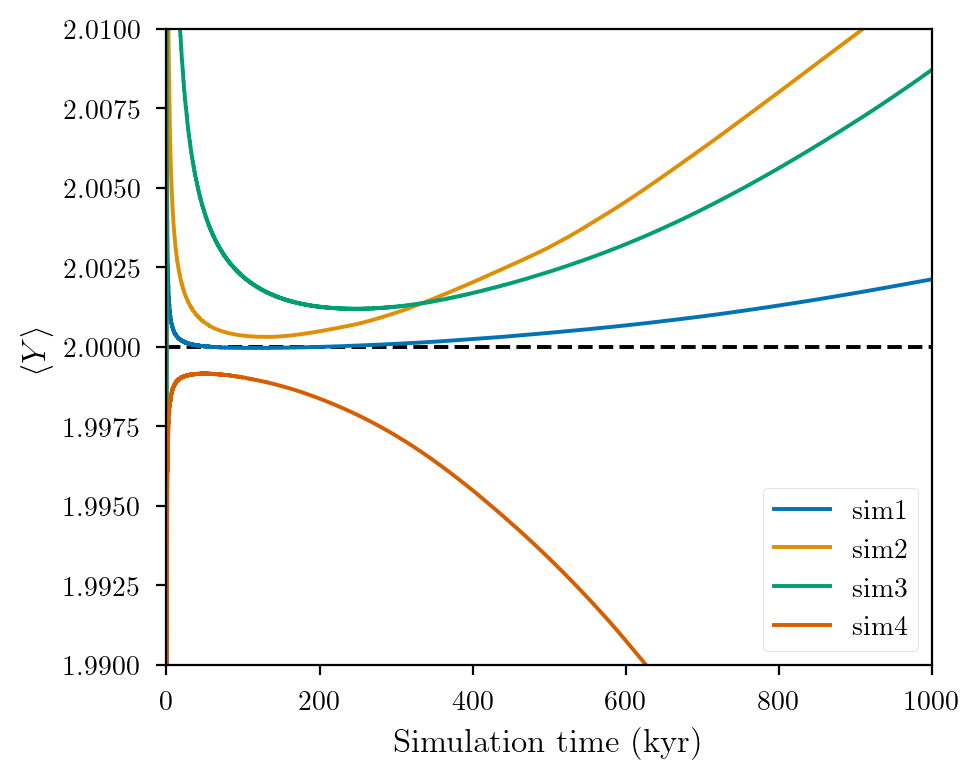

In [5]:
sims = [sim1, sim2, sim3, sim4]
names = ['sim1', 'sim2', 'sim3', 'sim4']
colors = sns.color_palette(palette='colorblind', n_colors=4)

fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)
ax.axhline(y=2., ls='--', c='k')
for i, sim in enumerate(sims):
    ax.plot(sim['time']/(2.*np.pi*1000.), sim['megno'], label=names[i], c=colors[i])
ax.set_xlim(0., 1000.)
ax.set_ylim(1.99, 2.01)
ax.set_xlabel('Simulation time (kyr)')
ax.set_ylabel(r'$\langle Y \rangle$')
ax.legend(loc=4);

After 1 Myr, $|\ddot{\langle Y \rangle}| > 0$ in each case.

# Planetary mass space

These data are referenced in Sect. 3 (Set II of the simulations).

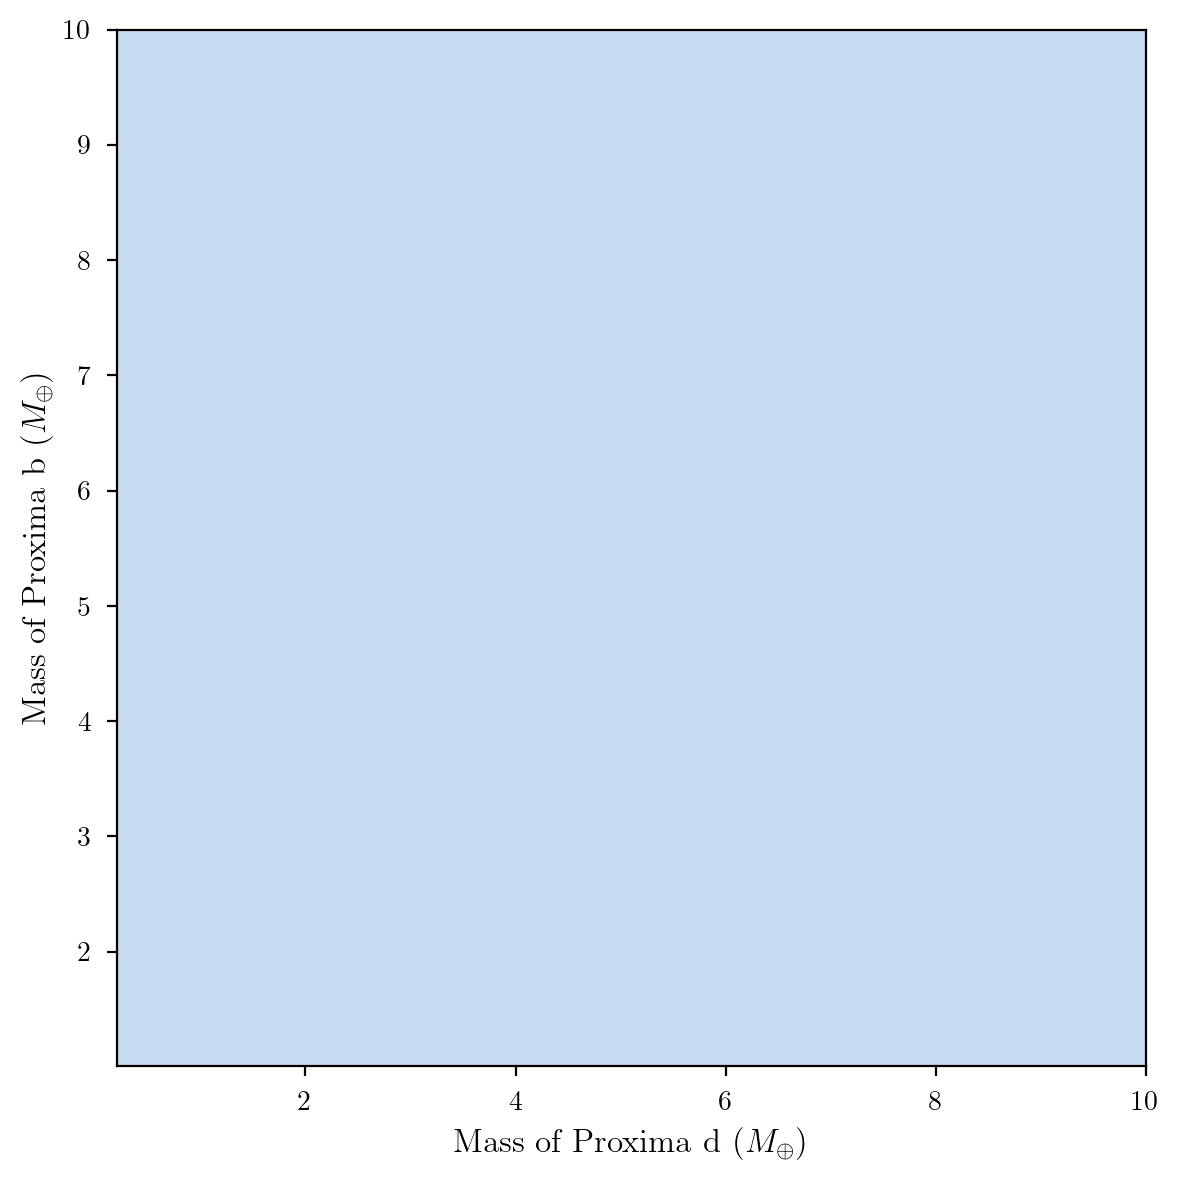

In [6]:
# megno_map_file = '~/Documents/GitHub/ProximaEvolution/hill-stability/mass-megno.txt'

megno_map_file = 'mass-megno.txt'

df = pd.read_csv(megno_map_file, sep=' ', names=column_names, index_col=False)

# Apply masks
stable_df = df.mask(np.fabs(df['megno'] - 2.) > 1.0e-2).dropna()
unstable_df = df.mask(np.fabs(df['megno'] - 2.) < 1.0e-2).dropna()
escape_df = df.mask(df['megno'] != 10.).dropna() # we arbitrarily set MEGNO to 10.0 where escape occurs

df = df.sort_values(by=['b_mass', 'd_mass'])

orbit_type = np.zeros((100, 100))
for k in range(len(df['megno'])):
    j = k % 100
    i = int(np.floor(k/100))
    if np.fabs(df['megno'].iloc[k] - 2.) <= 1e-2: # Criterion of Hinse et al. (2010)
        orbit_type[i][j] = 1. # quasi-periodic
    elif df['megno'].iloc[k] == 10.:
        orbit_type[i][j] = 0. # unstable -- ejection occurs
    else:
        orbit_type[i][j] = 0.5 # chaotic, but not necessarily unstable

# eccs = np.round_(np.linspace(0., 0.9, 100), decimals=2)
# ax = sns.heatmap(orbit_type, vmin=0., vmax=1., cmap='RdBu', xticklabels=[], yticklabels=[])
# ax.invert_yaxis();

X, Y = np.meshgrid(np.linspace(0.21, 10., 100), np.linspace(1.01, 10., 100))

fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=200)
ax.contourf(X, Y, orbit_type.T, cmap='Blues')
ax.set_xlabel(r'Mass of Proxima d ($M_\oplus$)')
ax.set_ylabel(r'Mass of Proxima b ($M_\oplus$)');

# plt.savefig('mass.png', dpi=400)

Note that the color here has no real significance. Every case displayed is quasi-periodic. An all-blue colormap was chosen to agree perceptually with the quasi-periodic cases in the previous figure.

# Inclination space

The following creates Fig. 3.

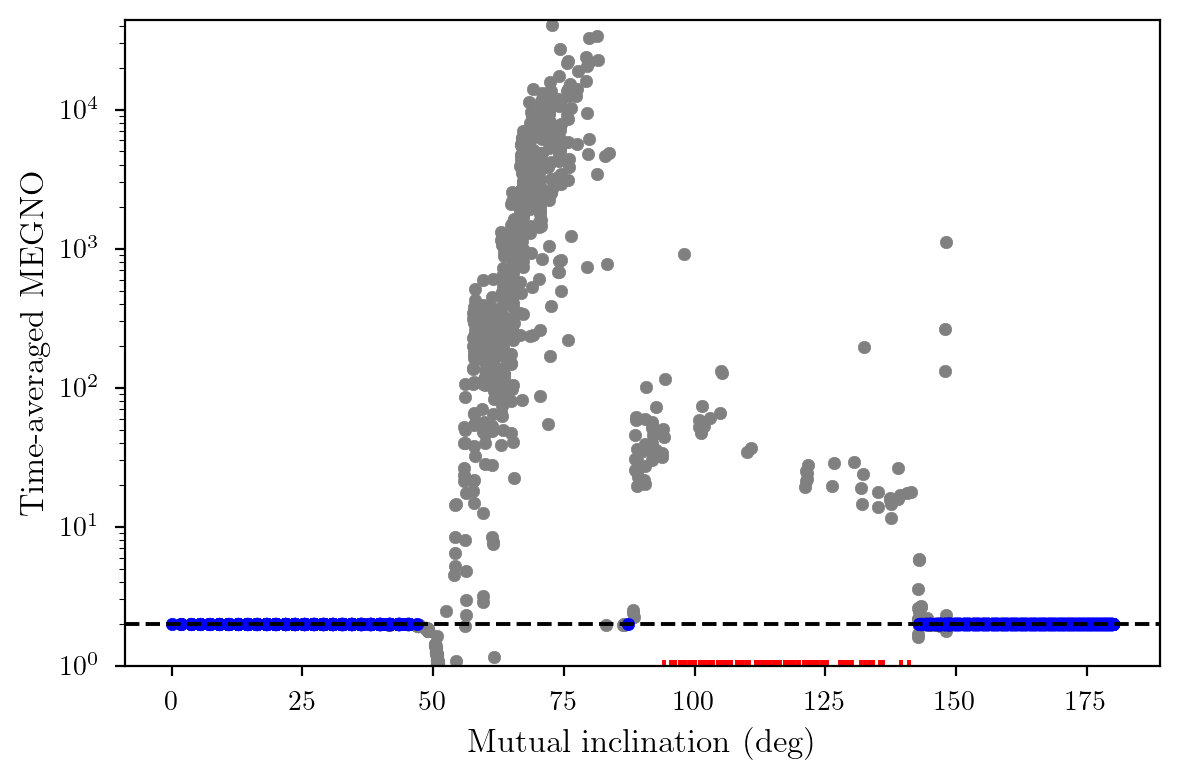

In [7]:
# megno_map_file = '~/Documents/GitHub/ProximaEvolution/hill-stability/inc-megno-2.txt'

megno_map_file = 'inc-megno.txt'

def mutual_inc(inc1, inc2, lasc1, lasc2):
    cosPsi = np.sin(inc1) * np.sin(inc2) * np.cos(lasc1 - lasc2) + np.cos(inc1) * np.cos(inc2)
    return np.arccos(cosPsi) * 180./np.pi

df = pd.read_csv(megno_map_file, sep=' ', names=column_names, index_col=False)

# Apply masks
periodic_df = df.mask(np.fabs(df['megno'] - 2.) > 1.0e-2).mask(df['megno'] == 10.).dropna()
chaotic_df = df.mask(np.fabs(df['megno'] - 2.) < 1.0e-2).mask(df['megno'] == 10.).dropna()
escape_df = df.mask(df['megno'] != 10.).dropna() # we arbitrarily set MEGNO to 10.0 where escape occurs

periodic_mutual_incs = mutual_inc(periodic_df['d_inc'], periodic_df['b_inc'], periodic_df['d_Omega'], periodic_df['b_Omega'])
chaotic_mutual_incs = mutual_inc(chaotic_df['d_inc'], chaotic_df['b_inc'], chaotic_df['d_Omega'], chaotic_df['b_Omega'])
escape_mutual_incs = mutual_inc(escape_df['d_inc'], escape_df['b_inc'], escape_df['d_Omega'], escape_df['b_Omega'])
escape_ticks = np.ones_like(escape_df['megno'])

fig, ax = plt.subplots(1, 1, dpi=200)
# ax.scatter(bound_mutual_incs, bound_df['megno'], s=20)
ax.scatter(escape_mutual_incs, escape_ticks, s=20, marker='|', c='r')
ax.scatter(chaotic_mutual_incs, chaotic_df['megno'], s=20, c='gray')
ax.scatter(periodic_mutual_incs, periodic_df['megno'], s=20, c='b')
ax.axhline(2., c='k', ls='--')
ax.set_ylim(bottom=1.)
ax.set_yscale('log')
ax.set_xlabel(r'Mutual inclination (deg)')
ax.set_ylabel('Time-averaged MEGNO');
# fig.savefig('mutual-incs.pdf', dpi=400, bbox_inches='tight');

In the range $95^\circ < \Psi < 142^\circ$, roughly $80\%$ of simulated cases result in instabilities.

In [8]:
num_chaos = len(chaotic_mutual_incs.mask(chaotic_mutual_incs > 142.).mask(chaotic_mutual_incs < 95.).dropna())
num_eject = len(escape_mutual_incs.mask(escape_mutual_incs > 142.).mask(escape_mutual_incs < 95.).dropna())
num_eject / (num_eject + num_chaos)

0.8159203980099502